# Visualize samples from msc_summary_turns dataset (`MSC-Segments' in thesis)

This notebook is meant for analysis and visualization of the MSC-Sessions dataset.

## Import libraries and load dataset

In [1]:
from dataset.msc_summary_turns import MSC_Turns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
from tabulate import tabulate

In [2]:
# Specify options for configuration of the dataset

configs_options = {
    "speaker_prefixes": [None, ["<other>", "<self>"]],
    "nofact_token": ['', "<nofact>"],
    "len_context": [2, 1, 3, 100],
}
basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
subsets = {
    1: ['train', 'valid', 'test'],
    2: ['train', 'valid', 'test'],
    3: ['train', 'valid', 'test'],
    4: ['valid', 'test']
}

In [3]:
# Define a set of configs to choose from

configs = {
    "default": {
        "speaker_prefixes": None,
        "nofact_token": '',
        "len_context": 2,
    }
}


In [4]:
# Set class-level configuration

MSC_Turns.set(**configs['default'])

In [5]:
# Load dataset with specified configuration

msc_turns = {
    session: {
        subset: MSC_Turns(basedir=basedir, sessions=[session], subset=subset) 
        for subset in subsets[session]
    }
    for session in subsets.keys()
}

In [6]:
# Load all the measurement information

m = {
    session: {subset: msc_turns[session][subset].measurements() for subset in subsets[session]}
    for session in subsets.keys()
}

## Show a few examples

In [7]:
for i in range(10):
    print(msc_turns[1]['train'][i])

("I need some advice on where to go on vacation, have you been anywhere lately?\nI have been all over the world. I'm military.", "I served or serve in the military. I've traveled the world.")
("I have been all over the world. I'm military.\nThat is good you have alot of travel experience", '')
('That is good you have alot of travel experience\nSure do. And a lot of experience blowing things up! Haha. Bora bora is nice.', "I've blown things up.")
("Sure do. And a lot of experience blowing things up! Haha. Bora bora is nice.\nI've been working non stop crazy hours and need a break.", "I've been working a lot of extra hours. I want to break from my non-stop work.")
("I've been working non stop crazy hours and need a break.\nThe best breaks are spent with cute cuddly kittens.", '')
('The best breaks are spent with cute cuddly kittens.\nBora bora sounds nice, you have been there before?', '')
('Bora bora sounds nice, you have been there before?\nNope... Just sounds nice, and repetitive. Bor

In [8]:
for i in range(10):
    print(msc_turns[4]['valid'][i])

("Do you have any new stunt double jobs coming  up?\nNo, I don't have any at this time.", 'I am a stunt double.')
("No, I don't have any at this time.\nYou must have a lot of free time to read then.  Are you reading anything good now?", 'I like reading.')
('You must have a lot of free time to read then.  Are you reading anything good now?\nI am reading The Butterfly Garden book, and it is good.  How was Fatal Charm?', 'I like reading. I am reading The Butterfly Garden.')
("I am reading The Butterfly Garden book, and it is good.  How was Fatal Charm?\nIt was very good, I love true crime books!  I'm definitely on the look out for something similar.  I spend a lot of time in the library, so I'll find something.", 'I like true crime books. I spend a lot of time in the library.')
("It was very good, I love true crime books!  I'm definitely on the look out for something similar.  I spend a lot of time in the library, so I'll find something.\nI also love True Crime!  Do you watch movies about

## Measurements overview with Pandas Dataframe

In [9]:
# Collect all item measurements in a dataframe

df_colums = list(m[1]['train']["allitem_measurements"][0].keys())
df = pd.DataFrame(columns=df_colums)

for session in subsets.keys():
    for subset in subsets[session]:
        subset_df = pd.DataFrame.from_dict(m[session][subset]["allitem_measurements"])

        subset_df["session"] = int(session)
        subset_df["subset"] = subset
        subset_df["hasfact"] = subset_df.apply(lambda row: row.labelwords > 0, axis=1).astype("boolean")
    
        df = pd.concat([df, subset_df])

# df["session"] = df["session"].astype(int)
df.head()


,session,dialog_id,turn_id,convai_id,inputwords,labelwords,subset,hasfact
0,1,0,0,train:ordered_3537,24,11,train,True
1,1,0,1,train:ordered_3537,18,0,train,False
2,1,0,2,train:ordered_3537,24,4,train,True
3,1,0,3,train:ordered_3537,26,16,train,True
4,1,0,4,train:ordered_3537,20,0,train,False


In [10]:
# Overview of statistics, by session and subset

df.groupby(["session", "subset"]).agg({'turn_id': ['count'], 'inputwords': ['mean', 'std'], 'labelwords': ['mean', 'std'], 'hasfact': ['mean']})

turn_id inputwords            labelwords             hasfact
                 count       mean        std       mean       std      mean
session subset                                                             
1       test      6071  22.297480   5.103456   5.456432  4.579091  0.732169
        train    55894  21.275522   4.912686   4.222027  4.114065  0.628422
        valid     7268  22.058200   4.618043   5.024216  4.565438   0.67639
2       test      5438  47.258735  19.211632   6.417249  6.591307   0.65833
        train    42420  48.463083  21.555953   5.648468  5.736532  0.655021
        valid     5397  48.416528  21.826136   6.516213  6.578711  0.661479
3       test      5423  50.285266  19.231950   6.853218  6.959560  0.664392
        train    24691  51.812928  21.869893   6.263335  6.314557  0.660241
        valid     5390  48.588126  20.656490   6.008905  6.100561   0.63859
4       test      5439  53.193050  21.282601   7.069866  6.956538  0.684501
        valid     5404  49.586788  19.719842   6.751850  7.107360  0.646743

In [11]:
### ***THESIS*** Table 4.2

# Make latex version for report

table_df = df.groupby(["session", "subset"]).agg({'turn_id': ['count'], 'inputwords': ['mean'], 'labelwords': ['mean'], 'hasfact': ['mean']})
table_df = table_df.unstack().swaplevel(1,2, axis=1).swaplevel(0,1, axis=1)[['train', 'valid', 'test']]
table_df = table_df.droplevel(level=2, axis=1)
total_row = df.groupby(['subset']).agg({'turn_id': ['count'], 'inputwords': ['mean'], 'labelwords': ['mean'], 'hasfact': ['mean']}).reindex(['train', 'valid', 'test'], level=1).values
table_df.loc['total'] = total_row.flatten()

s = table_df.style.format({
    ('train', 'turn_id'): '{:,.0f}',
    ('valid', 'turn_id'): '{:,.0f}',
    ('test', 'turn_id'): '{:,.0f}',
    ('train', 'inputwords'): '{:.0f}',
    ('valid', 'inputwords'): '{:.0f}',
    ('test', 'inputwords'): '{:.0f}',
    ('train', 'labelwords'): '{:.1f}',
    ('valid', 'labelwords'): '{:.1f}',
    ('test', 'labelwords'): '{:.1f}',
    ('train', 'hasfact'): '{:.0%}',
    ('valid', 'hasfact'): '{:.0%}',
    ('test', 'hasfact'): '{:.0%}',    
})
print(s.to_latex().replace('nan', ' ').replace('<NA>', ' ').replace('%', '\%'))
s

\begin{tabular}{lrrrrrrrrrrrr}
subset & \multicolumn{4}{r}{train} & \multicolumn{4}{r}{valid} & \multicolumn{4}{r}{test} \\
 & turn_id & inputwords & labelwords & hasfact & turn_id & inputwords & labelwords & hasfact & turn_id & inputwords & labelwords & hasfact \\
session &  &  &  &  &  &  &  &  &  &  &  &  \\
1 & 55,894 & 21 & 4.2 & 63\% & 7,268 & 22 & 5.0 & 68\% & 6,071 & 22 & 5.5 & 73\% \\
2 & 42,420 & 48 & 5.6 & 66\% & 5,397 & 48 & 6.5 & 66\% & 5,438 & 47 & 6.4 & 66\% \\
3 & 24,691 & 52 & 6.3 & 66\% & 5,390 & 49 & 6.0 & 64\% & 5,423 & 50 & 6.9 & 66\% \\
4 &   &   &   &   & 5,404 & 50 & 6.8 & 65\% & 5,439 & 53 & 7.1 & 68\% \\
total & 123,005 & 37 & 5.1 & 64\% & 23,459 & 41 & 6.0 & 66\% & 22,371 & 43 & 6.4 & 69\% \\
\end{tabular}



In [12]:
table_df.sum()

subset            
train   turn_id       246010.000000
        inputwords       158.332891
        labelwords        21.257540
        hasfact            2.587665
valid   turn_id        46918.000000
        inputwords       209.208915
        labelwords        30.292872
        hasfact            3.280646
test    turn_id        44742.000000
        inputwords       215.695789
        labelwords        32.217622
        hasfact            3.425594
dtype: float64

## Extract random subsets

In [13]:
# Select first and last turn of random selection of turns from each session

num_persubset = [10, 5, 5, 5]
sessions = [1, 2, 3, 4]
subset = 'valid'
extracted = {}

for persubset, s in zip(num_persubset, sessions):
    data = msc_turns[s][subset]
    extracted[s] = {'first': [], 'last': []}
    # print(s, len(data))
    dialog_ids = set([index['dialog_id'] for index in data.indices])
    selection = random.sample(range(len(dialog_ids)), persubset)
    print(s, len(dialog_ids), selection)
    turn_count_max = {i: -1 for i in selection}
    last_turn = {}
    # print(data.indices[0], turn_count_max)
    for idx, turn in zip(data.indices, data.turns):
        if idx['dialog_id'] in selection:
            if idx['turn_id'] == 0:
                # first turn
                extracted[s]['first'].append((idx, turn))
            if idx['turn_id'] > turn_count_max[idx['dialog_id']]:
                turn_count_max[idx['dialog_id']] = idx['turn_id']
                last_turn[idx['dialog_id']] = (idx, turn)
    # print(last_turn.values())
    extracted[s]['last'].extend(last_turn.values())

for s in sessions:
    for k, v in extracted[s].items():
        # print(v)
        for idx, turn in v:
            # print(t)
            print(f"{idx['session']}\t{idx['dialog_id']}\t{idx['turn_id']}\t{turn[0][1]}<sep>{turn[1][1]}")             



1 500 [348, 481, 112, 409, 382, 231, 290, 347, 456, 420]
2 500 [144, 72, 478, 279, 48]
3 500 [368, 295, 12, 59, 53]
4 500 [182, 260, 327, 234, 206]
1	112	0	Hi there, did you know I am super high maintenance?<sep>Well considering I do not know you? No, but I am too
1	231	0	Boy, I'm starving. Is it lunch time yet? I love to eat.<sep>I work at a convenience store if you want gas station food.
1	290	0	I just finished lunch shift at the restaurant. Made decent money today.<sep>That must be cool, you wait tables?
1	347	0	Hello my name is katrina and I deliver babies, I'm a nurse.<sep>Awesome. My babies are due in three months
1	348	0	Hello there who are you<sep>Hello, how are you today? I'm retired and enjoying it.
1	382	0	Good evening! How are you?<sep>I am good! I was just baking cookies. What about you?
1	409	0	Hi, what do you like to do?<sep>Hello, I'm a 20 year old man, I work in it. Do you like dogs?
1	420	0	Hi how are you this evening?<sep>Great! I'm larry here. A chef 80 of the time.

## Analyses

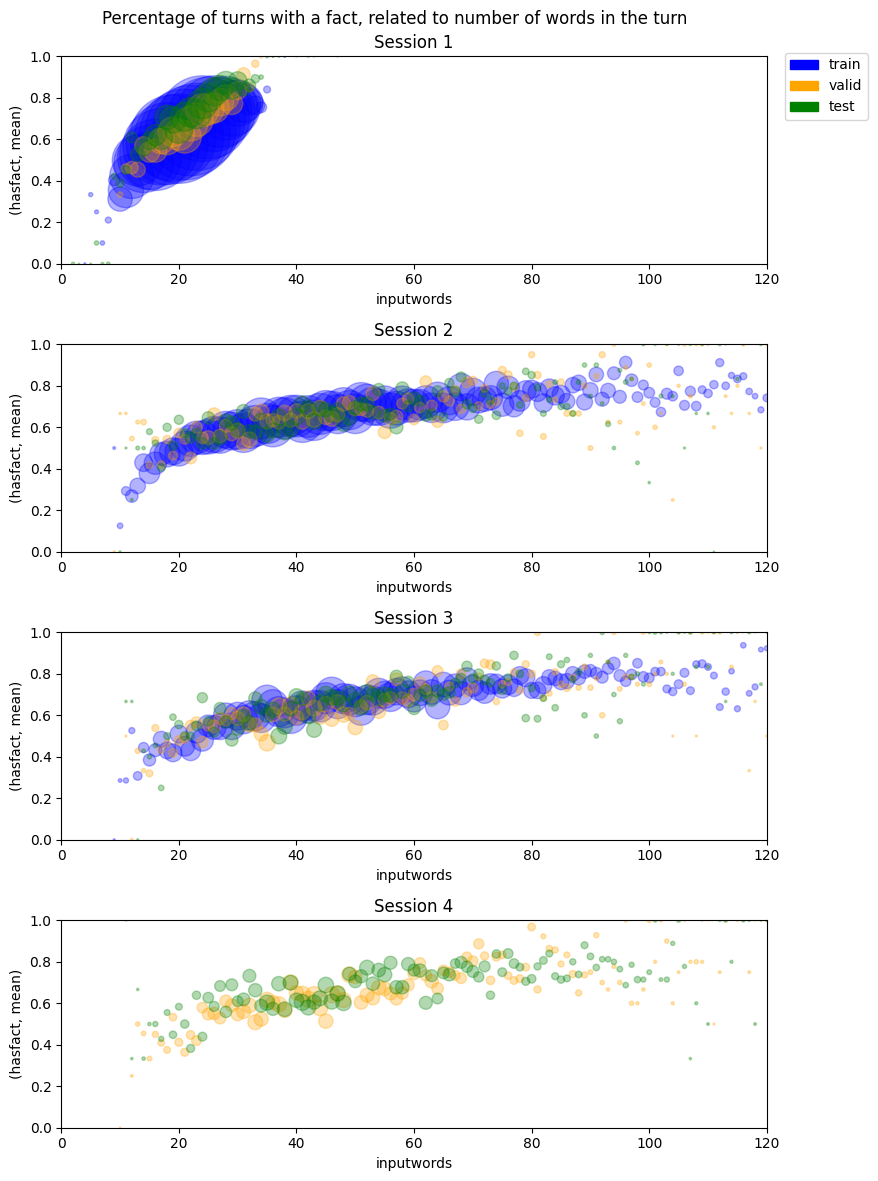

In [14]:
# Analyse relationship between length of input and probability of fact

fig, ax = plt.subplots(nrows=4, figsize=(8,12), sharex=False)
color = {'train': 'blue', 'valid':'orange', 'test':'green'}

def patches(labels):
    return [matplotlib.patches.Patch(color=color[label], label=label) for label in labels]

for i, session in enumerate(subsets.keys()):
    for subset in subsets[session]:
        selection = (df["session"] == session) & (df["subset"] == subset) & (df["inputwords"] <=120)
        df_hist = df[selection].groupby("inputwords", as_index=False).agg({"hasfact": ['mean', 'count']})
        scatter_ax = df_hist.plot.scatter(ax=ax[i], x='inputwords', y=('hasfact', 'mean'), s=('hasfact', 'count'), c=color[subset], alpha=0.3, ylim=(0,1), xlim=(0,120), label=subset)
    scatter_ax.legend_ = None
    scatter_ax.set_title(f"Session {session}")


fig.suptitle("Percentage of turns with a fact, related to number of words in the turn")
fig.legend(handles=patches(subsets[1]), bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()


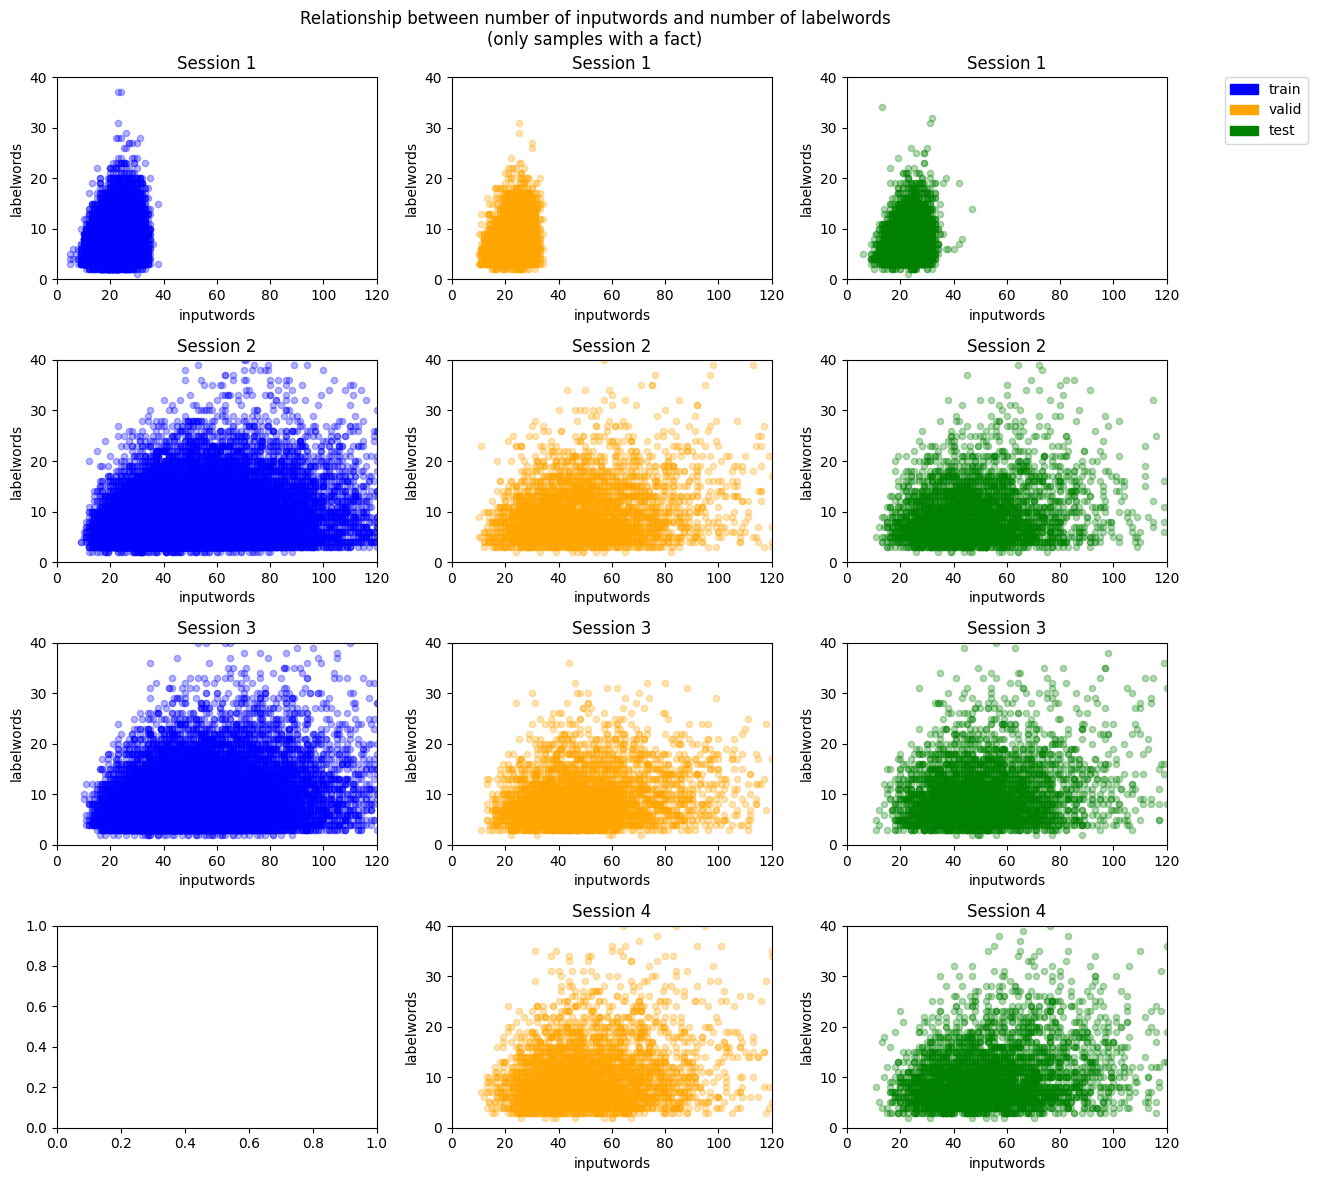

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
color = {'train': 'blue', 'valid':'orange', 'test':'green'}

def patches(labels):
    return [matplotlib.patches.Patch(color=color[label], label=label) for label in labels]

for i, session in enumerate(subsets.keys()):
    for j, subset in enumerate(subsets[session]):
        if session==4:
            j +=1
        selection = (df["session"] == session) & (df["subset"] == subset) & (df["inputwords"] <=120) & df["hasfact"]
        scatter_ax = df[selection].plot.scatter(ax=ax[i][j], x='inputwords', y='labelwords', c=color[subset], alpha=0.3, ylim=(0,40), xlim=(0,120), label=subset)
        scatter_ax.set_title(f"Session {session}")
        scatter_ax.legend_ = None
        

fig.legend(handles=patches(subsets[1]), bbox_to_anchor=(1.1, 0.93))
fig.suptitle("Relationship between number of inputwords and number of labelwords\n(only samples with a fact)")
fig.tight_layout()

/Users/FrankVerhoef/opt/miniconda3/envs/pex/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/FrankVerhoef/opt/miniconda3/envs/pex/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


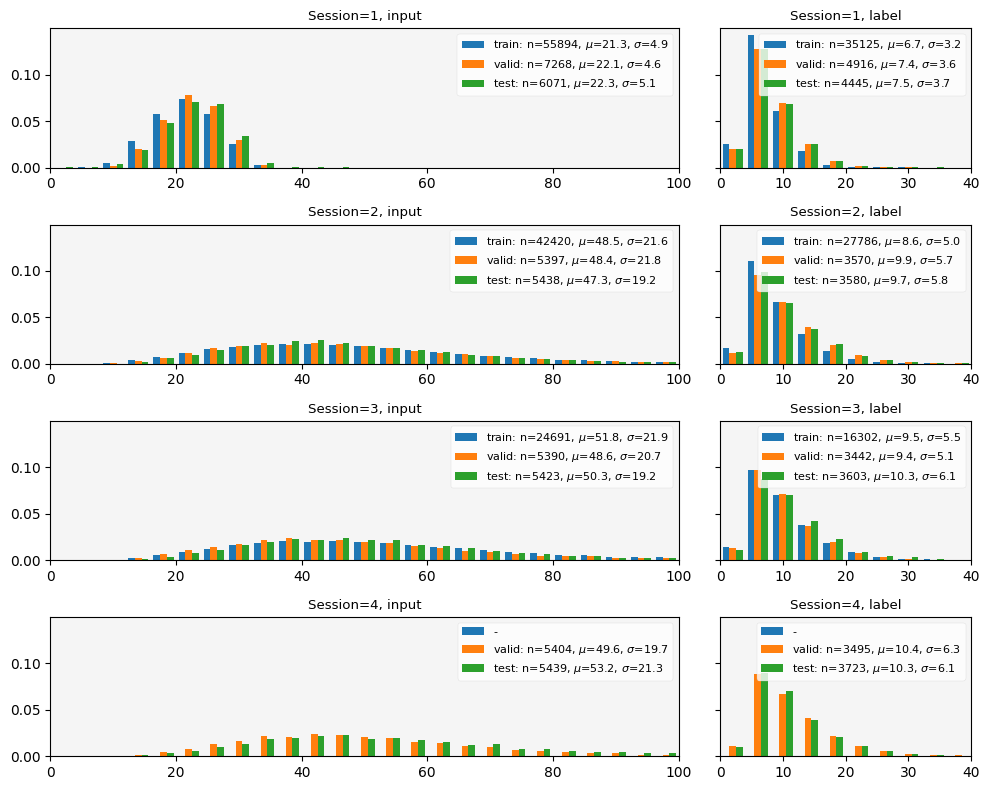

In [20]:
### ***THESIS*** Figure B.1

fig, ax = plt.subplots(ncols=2, nrows=len(subsets.keys()), figsize=(10, 8), gridspec_kw={'width_ratios': [10, 4]}, sharey=True)

def plot_hist_bar(ax, values, session, title, bins, range):
    labels = [f"{subset}: n={len(vals)}, " + r"$\mu$" + f"={vals.mean():.1f}, " + r"$\sigma$" + f"={vals.std():.1f}" for subset, vals in zip(subsets[session], values)]
    if session==4:
        labels = ['-'] + labels # add empty label
        values = [-1] + values # plot a bar, outside the range
    with plt.style.context('seaborn-v0_8-paper'):
        n, bins, patches = ax.hist(values, bins=bins, range=range, density=True, label=labels)
        legend = ax.legend()
        title = ax.set_title(title)
        ax.set_facecolor('whitesmoke')
        ax.set_xlim(range)
    return ax

for i, session in enumerate(subsets.keys()):
    m_input = [np.hstack([[val] * freq for val, freq in m[session][subset]['inputwords_per_sample']]) for subset in subsets[session]]
    m_label = [np.hstack([[val] * freq for val, freq in m[session][subset]['labelwords_per_sample'] if val != 0]) for subset in subsets[session]]
    bar_axes = plot_hist_bar(ax[i][0], m_input, session, title=f"Session={session}, input", bins=25, range=(0,100))
    bar_axes = plot_hist_bar(ax[i][1], m_label, session, title=f"Session={session}, label", bins=10, range=(0,40))

# fig.suptitle("Distribution of number of words per input sentence (one turn, with two utterances), and label (extracted facts)")

fig.tight_layout()
plt.savefig('../docs/msc_turns_distribution.pdf', dpi=300, format='pdf', bbox_inches='tight')

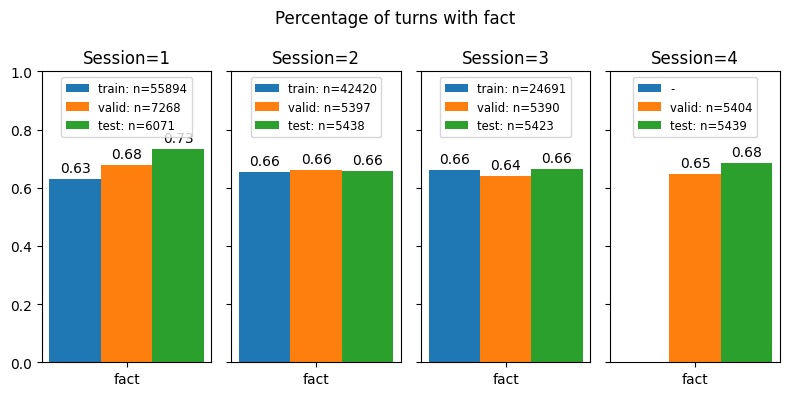

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(subsets.keys()), figsize=(8,4), sharey=True)
plt.ylim(0, 1.0)

def plot_bar(ax, values, session):
    x = np.arange(1)  # the label locations (only one label)
    width = 0.25  # the width of the bars
    multiplier = 0

    if session==4:
        bar = ax.bar(x=x, height=[0, 0], width=width, label='-')
        multiplier +=1

    for subset, valuedict in values.items():
        offset = width * multiplier
        height = np.array(list(valuedict.values())[1], dtype=float) / sum(valuedict.values())
        bar = ax.bar(x=x+offset, height=height, width=width, label=f"{subset}: n={sum(valuedict.values())}")
        ax.bar_label(bar, padding=3, fmt="{:.2f}")
        multiplier += 1

    legend = ax.legend()
    title = ax.set_title(f"Session={session}")
    ax.set_xticks(x + width, ["fact"])
    ax.legend(prop={"size": "small"}, loc="upper center")
    return ax

facts = {}
for i, session in enumerate(subsets.keys()):
    facts[session] = {}
    for subset in subsets[session]:
        facts[session][subset] = {False: 0, True: 0}
        for val, freq in m[session][subset]['labelwords_per_sample']:
            facts[session][subset][val > 0] += freq

    bar_axes = plot_bar(ax[i], facts[session], session)

fig.suptitle("Percentage of turns with fact")
fig.tight_layout()


## Test charts

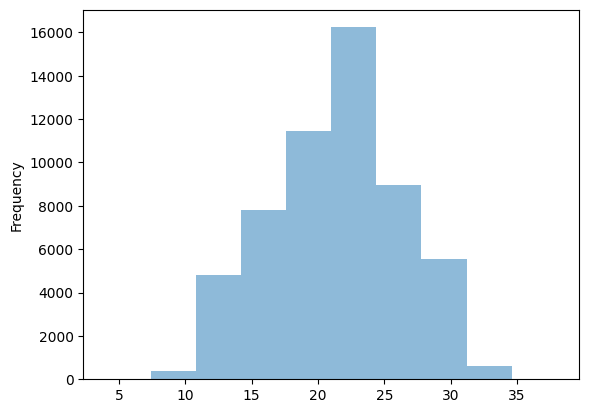

In [18]:
session=1
subset='train'

selection = (df["session"] == session) & (df["subset"] == subset)
ax = df[selection]["inputwords"].plot.hist(bins=10, alpha=0.5)

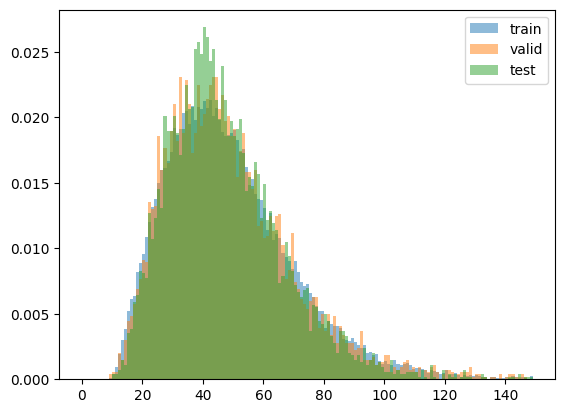

In [19]:
session=2

selection = df["session"] == session
for subset in subsets[session]:
    subset_df = df.loc[selection & (df["subset"] == subset), "inputwords"]
    plt.hist(subset_df, alpha=0.5, label=subset, density=True, bins=list(range(150)))
legend = plt.legend()

array([<Axes: title={'center': 'test'}>,
       <Axes: title={'center': 'train'}>,
       <Axes: title={'center': 'valid'}>], dtype=object)

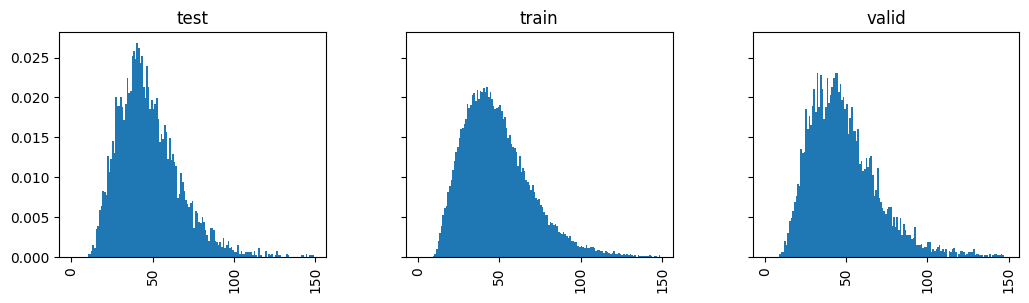

In [20]:
session=2

selection = df["session"] == session
df_hist = df[selection]
df_hist['inputwords'].hist(by=df_hist['subset'], bins=list(range(150)), layout=(1,3), figsize=(12,3), density=True, sharey=True)

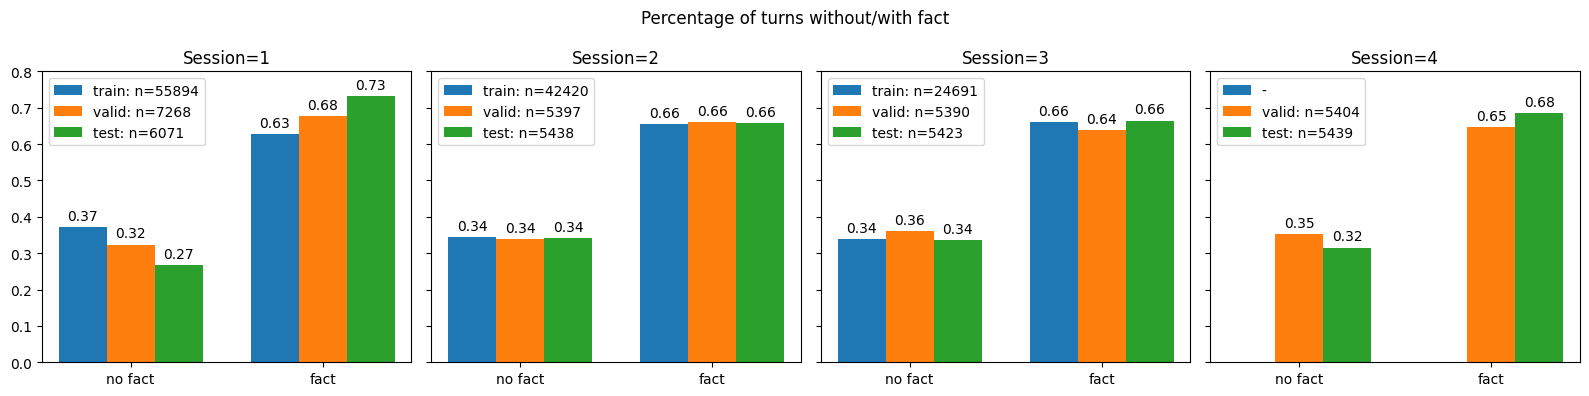

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=len(subsets.keys()), figsize=(16,4), sharey=True)
plt.ylim(0, 0.8)

def plot_bar(ax, values, session):
    x = np.arange(2)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    if session==4:
        bar = ax.bar(x=x, height=[0, 0], width=width, label='-')
        multiplier +=1

    for subset, valuedict in values.items():
        offset = width * multiplier
        height = np.array(list(valuedict.values()), dtype=float) / sum(valuedict.values())
        bar = ax.bar(x=x+offset, height=height, width=width, label=f"{subset}: n={sum(valuedict.values())}")
        ax.bar_label(bar, padding=3, fmt="{:.2f}")
        multiplier += 1

    legend = ax.legend()
    title = ax.set_title(f"Session={session}")
    ax.set_xticks(x + width, ["no fact", "fact"])
    return ax

facts = {}
for i, session in enumerate(subsets.keys()):
    facts[session] = {}
    for subset in subsets[session]:
        facts[session][subset] = {False: 0, True: 0}
        for val, freq in m[session][subset]['labelwords_per_sample']:
            facts[session][subset][val > 0] += freq

    bar_axes = plot_bar(ax[i], facts[session], session)

fig.suptitle("Percentage of turns without/with fact")
fig.tight_layout()